In [ ]:
! pip install torch matplotlib 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 MB 61.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 101.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.7/332.7 kB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 105.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 69.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 86.1 MB/s eta 0:00:00:00:0100:01

In [1]:
! python -c "import torch; print(torch.__version__, torch.version.cuda)"

2.9.1+cu130 13.0


In [1]:

# download dataset (uncomment in Colab)
# !wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt


In [2]:
import torch
torch.cuda.is_available()

True

In [15]:
batch_size = 128
block_size = 128
n_embd = 512
n_head = 8
n_layer = 12
dropout = 0.2
learning_rate = 2e-4
max_iters = 5000
eval_iters = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)


with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


class CharDataset(Dataset):
    """
    Emits batches of characters
    """
    def __init__(self, N, data, batch_size, device):
        self.N = N
        self.data = data
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        print('data has %d characters, %d unique.' % (data_size, vocab_size))

        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.vocab_size = vocab_size
        self.data_size = data_size
        self.batch_size = batch_size
        data_ix = torch.tensor([self.stoi[c] for c in data], dtype=torch.long)
        n = int(0.9 * len(data_ix))
        self.train_data = data_ix[:n]
        self.val_data = data_ix[n:]
        self.device = device


    def get_vocab_size(self):
        return self.vocab_size

    def __len__(self):
        return len(self.data) - self.N

    def __getitem__(self, idx):
        # grab a chunk of (N + 1) characters from the data
        chunk = self.data[idx:idx + self.N + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        # return as tensors
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y

    def get_batch(self, split):
        data = self.train_data if split == "train" else self.val_data
        ix = torch.randint(len(data) - self.N, (self.batch_size,))

        x = torch.stack([data[i:i+self.N] for i in ix])
        y = torch.stack([data[i+1:i+self.N+1] for i in ix])

        return x.to(self.device), y.to(self.device)
    
dataset = CharDataset(N=block_size, data=text, batch_size=batch_size, device=device)

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters, device=device)
        for k in range(eval_iters):
            X, Y = dataset.get_batch(split)
            _, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean().item()
    model.train()
    return out


class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head

        self.c_attn = nn.Linear(n_embd, 3 * n_embd)
        self.c_proj = nn.Linear(n_embd, n_embd)

        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)

        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))

    def forward(self, x):
        B, T, C = x.size()
        q, k, v = self.c_attn(x).split(C, dim=2)
        q = q.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = k.view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = v.view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_dim))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = self.attn_dropout(F.softmax(att, dim=-1))

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head, block_size, dropout=0.1):
        super().__init__()
        self.sa = CausalSelfAttention(n_embd, n_head, block_size, dropout)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPT(nn.Module):
    def __init__(self, vocab_size, n_embd, n_head, n_layer, block_size, dropout):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)

        self.blocks = nn.Sequential(*[Block(n_embd, n_head, block_size, dropout) for _ in range(n_layer)])

        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

        self.block_size = block_size

    def forward(self, idx, targets=None):
        B, T = idx.shape
        pos = torch.arange(T, device=idx.device)

        tok = self.token_emb(idx)
        pos_emb = self.pos_emb(pos)

        x = self.drop(tok + pos_emb)
        x = self.blocks(x)
        x = self.ln_f(x)

        logits = self.head(x)

        if targets is None:
            return logits, None

        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None, do_sample=True):
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            if do_sample:
                next_id = torch.multinomial(probs, num_samples=1)
            else:
                _, next_id = torch.topk(probs, k=1, dim=-1)
            idx = torch.cat((idx, next_id), dim=1)
        return idx


model = GPT(dataset.get_vocab_size(), n_embd, n_head, n_layer, block_size, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.1)

T_max = max_iters
scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)


checkpoint_dir = "download"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "gpt_checkpoint.pth")

def save_checkpoint(model, optimizer, step, path, stoi, itos):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "step": step,
        "stoi": stoi,
        "itos": itos
    }, path)
    print(f"Saved checkpoint step {step} -> {path}")

def load_checkpoint(model, optimizer, path):
    if os.path.exists(path):
        ckpt = torch.load(path, map_location=device)
        model.load_state_dict(ckpt["model_state_dict"])
        optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        start_step = ckpt["step"] + 1
        print(f"Loaded checkpoint from step {ckpt['step']}, resuming at {start_step}")
        return start_step
    else:
        print("No checkpoint found, starting from scratch")
        return 0


start_step = load_checkpoint(model, optimizer, checkpoint_path)


model.train()


train_losses = []
val_losses = []
steps = []


step = start_step
while step <= max_iters:
    xb, yb = dataset.get_batch("train")
    logits, loss = model(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    scheduler.step()


    if step % eval_iters == 0:
        losses = estimate_loss(model)
        train_loss = losses['train']
        val_loss = losses['val']
        print(f"step {step}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        steps.append(step)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        
        save_checkpoint(model, optimizer, step, checkpoint_path, dataset.stoi, dataset.itos)

    step += 1
    if step > max_iters:
        break


model.eval()
seed = "O God, O God!"
input_ids = torch.tensor([[dataset.stoi.get(c, 0) for c in seed]], dtype=torch.long).to(device)
out = model.generate(input_ids, max_new_tokens=400, temperature=0.8, top_k=40, do_sample=True)
generated = "".join(dataset.itos[int(i)] for i in out[0].tolist())
print("\n=== GENERATED ===\n")
print(generated)


device: cuda
data has 1115394 characters, 65 unique.
No checkpoint found, starting from scratch
step 0: train loss 4.0185, val loss 4.0552
Saved checkpoint step 0 -> download/gpt_checkpoint.pth
step 200: train loss 2.3004, val loss 2.3220
Saved checkpoint step 200 -> download/gpt_checkpoint.pth
step 400: train loss 1.9064, val loss 1.9999
Saved checkpoint step 400 -> download/gpt_checkpoint.pth
step 600: train loss 1.6807, val loss 1.8315
Saved checkpoint step 600 -> download/gpt_checkpoint.pth
step 800: train loss 1.5548, val loss 1.7363
Saved checkpoint step 800 -> download/gpt_checkpoint.pth
step 1000: train loss 1.4720, val loss 1.6706
Saved checkpoint step 1000 -> download/gpt_checkpoint.pth
step 1200: train loss 1.4155, val loss 1.6221
Saved checkpoint step 1200 -> download/gpt_checkpoint.pth
step 1400: train loss 1.3731, val loss 1.6002
Saved checkpoint step 1400 -> download/gpt_checkpoint.pth
step 1600: train loss 1.3328, val loss 1.5678
Saved checkpoint step 1600 -> download/g

In [16]:
# temperature 0.8
model.eval()
seed = "O God, O God!"
input_ids = torch.tensor([[dataset.stoi.get(c, 0) for c in seed]], dtype=torch.long).to(device)
out = model.generate(input_ids, max_new_tokens=400, temperature=0.8, top_k=40, do_sample=True)
generated = "".join(dataset.itos[int(i)] for i in out[0].tolist())
print("\n=== GENERATED temperature 0.8 ===\n")
print(generated)


=== GENERATED temperature 0.8 ===

O God, O God! my tongue, that one hands
Which a were enemy private and service
Which we was false wedded for the treason.

ANGELO:
I say you, lords, of late!

GREGORY:
Ay, you enough, and, and die not with so cruel appeach.

POLIXENES:
I will was not fourteen.

BALTHASAR:
The mayor so, then I cannot do it be.

BUCKINGHAM:
Where is the counting news of his brother?

GLOUCESTER:
And what father than you this cha


In [17]:
# temperature 0.1
model.eval()
seed = "O God, O God!"
input_ids = torch.tensor([[dataset.stoi.get(c, 0) for c in seed]], dtype=torch.long).to(device)
out = model.generate(input_ids, max_new_tokens=400, temperature=0.1, top_k=40, do_sample=True)
generated = "".join(dataset.itos[int(i)] for i in out[0].tolist())
print("\n=== GENERATED ===\n")
print(generated)


=== GENERATED ===

O God, O God! what a king?

GLOUCESTER:
The common could be so false the world and the common
That we should be so bring the world of the state,
And therefore the sea that have been so so sound.

GLOUCESTER:
The great shall be the contrary to the prince.

KING EDWARD IV:
Why, then the country shall be the contrary.

KING RICHARD III:
Why, then the country will be the contrary.

QUEEN ELIZABETH:
The king is the


In [18]:
# temperature 0.5
model.eval()
seed = "O God, O God!"
input_ids = torch.tensor([[dataset.stoi.get(c, 0) for c in seed]], dtype=torch.long).to(device)
out = model.generate(input_ids, max_new_tokens=400, temperature=0.5, top_k=40, do_sample=True)
generated = "".join(dataset.itos[int(i)] for i in out[0].tolist())
print("\n=== GENERATED ===\n")
print(generated)


=== GENERATED ===

O God, O God! O God! how behind the world!

GLOUCESTER:
And come to your grace against the earth,
And so I can will speak for the other's gate,
To see the triumph of the mind of the rest.

BUCKINGHAM:
But so I, that she hath promised and sentence
That is no more born to the life of the broke.

CLARENCE:
The careful cannot close the matter scarce
Than the court of the duke of God,
That will be her beauty of the


In [19]:
# temperature 1
model.eval()
seed = "O God, O God!"
input_ids = torch.tensor([[dataset.stoi.get(c, 0) for c in seed]], dtype=torch.long).to(device)
out = model.generate(input_ids, max_new_tokens=400, temperature=1, top_k=40, do_sample=True)
generated = "".join(dataset.itos[int(i)] for i in out[0].tolist())
print("\n=== GENERATED ===\n")
print(generated)


=== GENERATED ===

O God, O God!
And say thee and men's infection
A dranged of the fatal break, a maid-friend hence!

KING RICHARD III:
He has not forsaked the block in pain
With her breedy proper to be his tents,
In all the three-blood after the ancient
To Marcius was the first pleasure of this shame;
And therefore he hath set the rosemary.

QUEEN MARGARET:
Why, my good Lord Uly of Willshire a blood
Beride the stirr'd of noble 


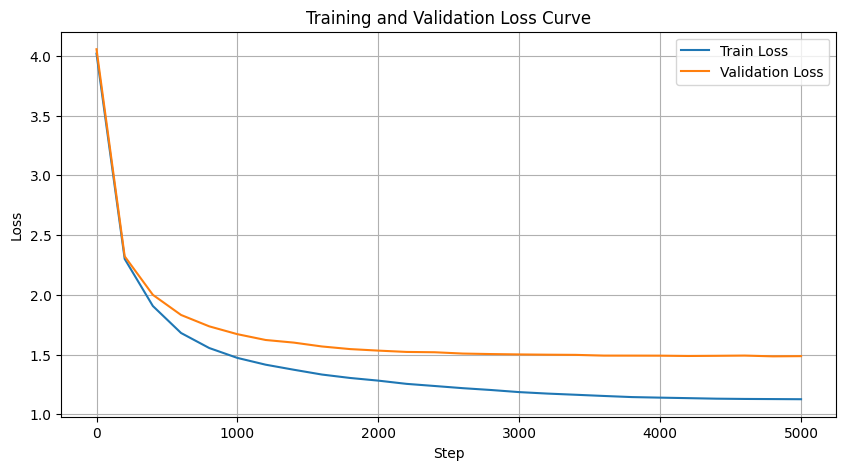

In [20]:
plt.figure(figsize=(10,5))
plt.plot(steps, train_losses, label="Train Loss")
plt.plot(steps, val_losses, label="Validation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()
